In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv('data/Thailand_M.csv', usecols=['dateid01', 'p'], index_col='dateid01', parse_dates=True)
df.index.freq = 'MS'
df

,p
dateid01,
2003-01-01,2.36
2003-02-01,2.13
2003-03-01,1.82
2003-04-01,1.50
2003-05-01,1.83
...,...
2014-08-01,2.12
2014-09-01,1.73
2014-10-01,1.45


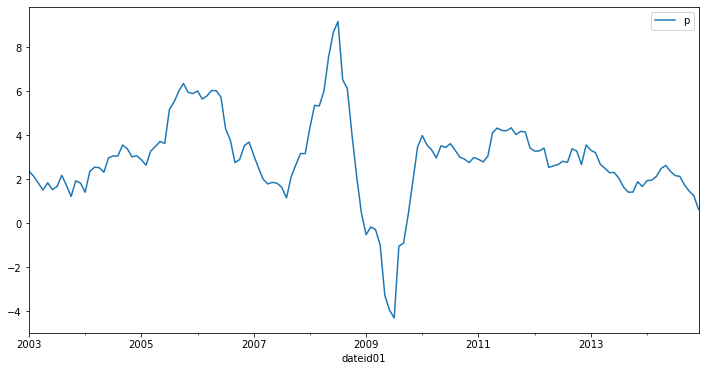

In [9]:
# Always plot your data

df.plot(figsize=(12, 6));

Calculating AR(1) Forecasts for Thailand

Assume that you are in December 2013 and just observed inflation in December 2013. You are interested in forecasting monthly year-on-year inflation for all months of 2014. In other words, you would like to perform a dynamic forecast. 

In [621]:
train = df.assign(lagp=df.p.shift(1)).dropna().loc[:'2013-12-01']
test = df.assign(lagp=df.p.shift(1)).dropna().loc['2014-01-01':]
test

,p,lagp
dateid01,,
2014-01-01,1.93,1.66
2014-02-01,1.95,1.93
2014-03-01,2.12,1.95
2014-04-01,2.48,2.12
2014-05-01,2.62,2.48
2014-06-01,2.35,2.62
2014-07-01,2.16,2.35
2014-08-01,2.12,2.16
2014-09-01,1.73,2.12


## Question 4.16

Note that the lecturer presented, in the Excel sheet, an AR(1) model estimated with OLS. To replicate, we must use the `dynamic_pred()` helper function from the `utils_statsmodels` file.

Using the AR(1) model, the forecast of Thai inflation for December, 2014 is:

In [622]:
from utils_statsmodels import dynamic_pred

ar1 = smf.ols('p ~ lagp', data=train).fit()
ar1_pred = dynamic_pred(ar1, test, 'lagp').loc[:, ['mean']]
ar1_pred

,mean
dateid01,
2014-01-01,1.740946
2014-02-01,1.816707
2014-03-01,1.887616
2014-04-01,1.953983
2014-05-01,2.016098
2014-06-01,2.074236
2014-07-01,2.128649
2014-08-01,2.179577
2014-09-01,2.227243


The answer to the question is $2.35\%$.

In real life, however, you would want to use `SARIMAX()` to predict:

In [47]:
ar1b = SARIMAX(df.loc[:'2013-12-01'].p, order=(1, 0, 0), trend='c').fit(disp=0)
ar1b.predict(test.index[0], test.index[-1], dynamic=True)

/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2014-01-01    1.741971
2014-02-01    1.818207
2014-03-01    1.889108
2014-04-01    1.955047
2014-05-01    2.016373
2014-06-01    2.073408
2014-07-01    2.126451
2014-08-01    2.175783
2014-09-01    2.221663
2014-10-01    2.264333
2014-11-01    2.304017
2014-12-01    2.340924
Freq: MS, Name: predicted_mean, dtype: float64

## Question 4.17

Let's reconstruct the excel sheet as a DataFrame

In [62]:
df2 = (
    ar1_pred
    .rename(columns={'mean':'ar1'})
    .assign(
        naive=train.p[-1],
        observed=test.p)
    .assign(
        e_ar=lambda x: x.ar1 - x.observed,
        e_nv=lambda x: x.naive - x.observed
    )
)

df2

,ar1,naive,observed,e_ar,e_nv
dateid01,,,,,
2014-01-01,1.740946,1.66,1.93,-0.189054,-0.27
2014-02-01,1.816707,1.66,1.95,-0.133293,-0.29
2014-03-01,1.887616,1.66,2.12,-0.232384,-0.46
2014-04-01,1.953983,1.66,2.48,-0.526017,-0.82
2014-05-01,2.016098,1.66,2.62,-0.603902,-0.96
2014-06-01,2.074236,1.66,2.35,-0.275764,-0.69
2014-07-01,2.128649,1.66,2.16,-0.031351,-0.50
2014-08-01,2.179577,1.66,2.12,0.059577,-0.46
2014-09-01,2.227243,1.66,1.73,0.497243,-0.07


In [60]:
df2.describe().loc[['mean', 'std'], :]

,ar1,naive,observed
mean,2.080268,1.66,1.897500
std,0.200226,0.00,0.566522


## Question 4.18

In [73]:
(
    df2
    .assign(
        abs_e_ar=np.abs(df2.e_ar),
        abs_e_nv=np.abs(df2.e_nv)
    )
    .query('abs_e_ar == abs_e_ar.max() | abs_e_nv == abs_e_nv.max()')
)

,ar1,naive,observed,e_ar,e_nv,abs_e_ar,abs_e_nv
dateid01,,,,,,,
2014-12-01,2.352692,1.66,0.62,1.732692,1.04,1.732692,1.04


Both models perform worst in December 2014.

## Question 4.19

Bias --> mean forecast error

In [74]:
df2

,ar1,naive,observed,e_ar,e_nv
dateid01,,,,,
2014-01-01,1.740946,1.66,1.93,-0.189054,-0.27
2014-02-01,1.816707,1.66,1.95,-0.133293,-0.29
2014-03-01,1.887616,1.66,2.12,-0.232384,-0.46
2014-04-01,1.953983,1.66,2.48,-0.526017,-0.82
2014-05-01,2.016098,1.66,2.62,-0.603902,-0.96
2014-06-01,2.074236,1.66,2.35,-0.275764,-0.69
2014-07-01,2.128649,1.66,2.16,-0.031351,-0.50
2014-08-01,2.179577,1.66,2.12,0.059577,-0.46
2014-09-01,2.227243,1.66,1.73,0.497243,-0.07


In [77]:
df2.describe().loc[['mean'], ['e_ar', 'e_nv']]

,e_ar,e_nv
mean,0.182768,-0.2375


## Question 4.20

In [81]:
mse_ar = np.mean([x**2 for x in df2.e_ar])
mse_nv = np.mean([x**2 for x in df2.e_nv])

print(f'MSE AR(1): {mse_ar}')
print(f'RMSE AR(1): {np.sqrt(mse_ar)}\n')

print(f'MSE Naive: {mse_nv}')
print(f'RMSE Naive: {np.sqrt(mse_nv)}')

MSE AR(1): 0.49225341486206725
RMSE AR(1): 0.7016077357484503

MSE Naive: 0.35060833333333347
RMSE Naive: 0.5921218906047415


## Question 4.21

$MSE = SE^2 + BIAS^2$

In [88]:
bias_ar = np.mean(df2.e_ar)
bias_nv = np.mean(df2.e_nv)

se_ar = np.sqrt(mse_ar - bias_ar**2)
se_nv = np.sqrt(mse_nv - bias_nv**2)

print(f'SE AR(1): {se_ar}')
print(f'SE Naive: {se_nv}')

se_ar > se_nv

SE AR(1): 0.6773841742723586
SE Naive: 0.5424039853590066


True

In [90]:
mae_ar = np.mean(np.abs(df2.e_ar))
mae_nv = np.mean(np.abs(df2.e_nv))

print(f'MAE AR(1): {mae_ar}')
print(f'MAE Naive: {mae_nv}')

MAE AR(1): 0.514728684769219
MAE Naive: 0.5158333333333335


## Question 4.22

## Question 4.23

In [143]:
df2b = (
    df2
    .eval("""
    mpe_ar = 100*(e_ar/observed)
    mpe_nv = 100*(e_nv/observed)
    abs_mpe_ar = abs(mpe_ar)
    abs_mpe_nv = abs(mpe_nv)    
    """)
)

df2b.head()

,ar1,naive,observed,e_ar,e_nv,mpe_ar,mpe_nv,abs_mpe_ar,abs_mpe_nv
dateid01,,,,,,,,,
2014-01-01,1.740946,1.66,1.93,-0.189054,-0.27,-9.795541,-13.989637,9.795541,13.989637
2014-02-01,1.816707,1.66,1.95,-0.133293,-0.29,-6.835522,-14.871795,6.835522,14.871795
2014-03-01,1.887616,1.66,2.12,-0.232384,-0.46,-10.961513,-21.698113,10.961513,21.698113
2014-04-01,1.953983,1.66,2.48,-0.526017,-0.82,-21.210376,-33.064516,21.210376,33.064516
2014-05-01,2.016098,1.66,2.62,-0.603902,-0.96,-23.049676,-36.641221,23.049676,36.641221


In [144]:
(
    df2b
    .loc[:, ['mpe_ar', 'mpe_nv', 'abs_mpe_ar', 'abs_mpe_nv']]
    .apply(np.mean)
)

mpe_ar        30.770136
mpe_nv         1.464681
abs_mpe_ar    44.943255
abs_mpe_nv    34.551263
dtype: float64

**Calculating U1**

$U_1 = \frac{\sqrt(\frac{1}{f}\sum^f_1 (\hat{y} - y)^2)}{\sqrt(\frac{1}{f}\sum^f_1 \hat{y}^2) + \sqrt(\frac{1}{f}\sum^f_1 y^2)}$

In [156]:
def theil_u1(fcast, observed):
    # a / (b1 + b2)
    
    a = np.sqrt(np.mean((fcast - observed)**2))
    b1 = np.sqrt(np.mean(fcast**2))
    b2 = np.sqrt(np.mean(observed**2))

    return a / (b1 + b2)



## Question 4.31

In [153]:
for fcast in [df2b.ar1, df2b.naive]:
    print(f'{fcast.name}: U1 = {theil_u1(fcast, df2b.observed)}')

ar1: U1 = 0.17269988707347675
naive: U1 = 0.16296178325008465


**Calculating U2**

$U_2 = \sqrt(\frac{\frac{1}{f}\sum^f_1 \frac{(\hat{y} - y)}{\bar{y}}^2}{\frac{1}{f}\sum^f_1 \frac{\bar{y} - y}{\bar{y}}^2})$

In [158]:
def theil_u2(fcast, observed, benchmark, last_obs):
    # sqrt(a / b)
    
    a = np.mean(((fcast - observed)/last_obs)**2)
    b = np.mean(((benchmark - observed)/last_obs)**2)
    

    return np.sqrt(a / b)

## Question 4.32

The answer to this question requires rounding.

In [191]:
np.round(np.mean(((df2b.e_ar)/train.p[-1])**2), decimals=2)

0.18

In [192]:
np.round(np.mean(((df2b.e_nv)/train.p[-1])**2), decimals=2)

0.13

## Question 4.33

## Question 4.34

In [193]:
for fcast in [df2b.ar1, df2b.naive]:
    print(f'{fcast.name}: U2 = {np.round(theil_u2(fcast, df2b.observed, df2b.naive, train.p[-1]), 2)}')

ar1: U2 = 1.18
naive: U2 = 1.0


## Question 4.35

Calculate the Bias, Variance, and Covariance proportions for both model.

In [203]:
bias_prop = bias_ar**2/mse_ar
var_prop = (np.std(df2b.ar1) - np.std(df2b.observed))**2/mse_ar
cov_prop = 2*(1-np.corrcoef(df2b.observed, df2b.ar1)[0, 1])*np.std(df2b.ar1) * np.std(df2b.observed)/mse_ar

print(f'AR(1) Bias Proportion: {np.round(bias_prop, 2)}')
print(f'AR(1) Variance Proprtion: {np.round(var_prop, 2)}')
print(f'AR(1) Covariance Proportion: {np.round(cov_prop, 2)}')

AR(1) Bias Proportion: 0.07
AR(1) Variance Proprtion: 0.25
AR(1) Covariance Proportion: 0.68


In [202]:
# Check that sums to 1
bias_prop + var_prop + cov_prop

1.0000000000000002

## Question 4.36

In [211]:
bias_prop = bias_nv**2/mse_nv
var_prop = (np.std(df2b.naive) - np.std(df2b.observed))**2/mse_nv
cov_prop = 2*(1-np.corrcoef(df2b.observed, df2b.naive)[0, 1])*np.std(df2b.naive) * np.std(df2b.observed)/mse_nv

print(f'Naive Bias Proportion: {np.round(bias_prop, 2)}')
print(f'Naive Variance Proprtion: {np.round(var_prop, 2)}')
print(f'Naive Covariance Proportion: {np.round(cov_prop, 2)}')

Naive Bias Proportion: 0.16
Naive Variance Proprtion: 0.84
Naive Covariance Proportion: nan


/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


# Rolling and Expanding windows forecast

To replicate the results in the lectures, we need to use a locally created `dyn_pred()` function that estimates the AR models dynamically via OLS.

In [268]:
df3 = df.eval('lp = p.shift(1)', engine='python').dropna()

In [280]:
df3.p[-2]

1.24

In [554]:
def dyn_pred(X, y, steps, nlags=1, months=1, freq='MS'):
    """
    Takes a vector X of lagged dependent variables, a vector y of the dependent variable,
    and forecasts y dynamically n steps ahead.
    """
    
    last_date = X.index[-1]
    last_y = y[-1]
    
    if nlags == 1:
        X_test = np.array([1, last_y])

    if nlags == 2:
        lag_last_y = y[-2]
        X_test = np.array([1, last_y, lag_last_y])


    X = np.column_stack((np.ones(X.shape[0]), X))
    params = np.linalg.lstsq(X, y)[0]


    predictions = []
    pred_index = pd.date_range(last_date + pd.DateOffset(months=months), periods=steps, freq=freq)
    
    for i in range(steps):
        predict = np.dot(params, X_test)
        predictions.append(predict)
        if nlags == 1:
            X_test = np.array([1, predict])
        
        if nlags == 2:
            lag_last_y = last_y
            last_y = predict
            X_test = np.array([1, last_y, lag_last_y])

    return pd.Series(predictions, index=pred_index)

dyn_pred(df3.lp, df3.p, 4)

2015-01-01    0.746291
2015-02-01    0.864984
2015-03-01    0.976536
2015-04-01    1.081376
Freq: MS, dtype: float64

In [555]:
f1_predictions = []
f1_sq_errors = []
f1_bias = []

for i in pd.date_range("2008-12-01", periods=50, freq='MS'):
    preds = dyn_pred(df3[:i].lp, df3[:i].p, steps=6)
    obs = df3[(i+ pd.DateOffset(months=1)):(i+ pd.DateOffset(months=6))].p
    
    # Check that we're using the correct dates
    assert all(preds.index == obs.index)

    bias = (preds.values - obs.values)
    sqe = (bias)**2

    f1_predictions.append(preds)
    f1_sq_errors.append(sqe)
    f1_bias.append(bias)

f1_sq_errors = np.stack(f1_sq_errors)
f1_bias = np.stack(f1_bias)

df4 = df3.eval('llp = lp.shift(1)', engine='python').dropna()

f2_predictions = []
f2_sq_errors = []
f2_bias = []

for i in pd.date_range("2008-12-01", periods=50, freq='MS'):
    preds = dyn_pred(df4.loc[:i, ['lp', 'llp']], df4[:i].p, steps=6, nlags=2)
    obs = df4[(i+ pd.DateOffset(months=1)):(i+ pd.DateOffset(months=6))].p
    
    # Check that we're using the correct dates
    assert all(preds.index == obs.index)

    bias = (preds.values - obs.values)
    sqe = (bias)**2

    f2_predictions.append(preds)
    f2_sq_errors.append(sqe)
    f2_bias.append(bias)

f2_sq_errors = np.stack(f2_sq_errors)
f2_bias = np.stack(f2_bias)



Before answering the questions, let's see how the models perform:

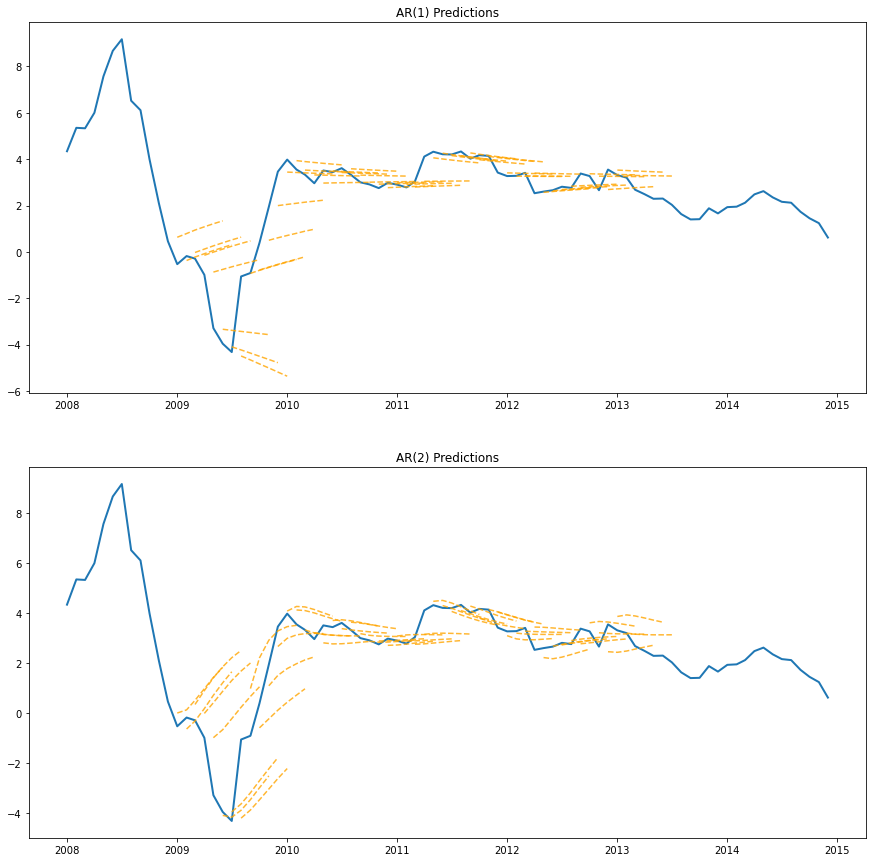

In [556]:
fig, ax = plt.subplots(2, 1, figsize=(15, 15))

ax[0].plot(df.loc["2008-01-01":].p, lw=2)
ax[0].set_title('AR(1) Predictions')
ax[1].plot(df.loc["2008-01-01":].p, lw=2)
ax[1].set_title('AR(2) Predictions')

for predictions in f1_predictions:
    ax[0].plot(predictions, ls='--', alpha=.8, color='orange')

for predictions in f2_predictions:
    ax[1].plot(predictions, ls='--', alpha=.8, color='orange')

We see that they both perform equally poorly, especially between 2008 and 2010

## Question 4.40

What is the RMSE of the AR(1) model for horizon 4?

In [557]:
print(f'AR(1) RMSE: {np.round(np.sqrt(np.mean(f1_sq_errors[:, 3])), 3)}')

AR(1) RMSE: 1.968


## Question 4.41

Let’s now compare the ability of the AR(1)  and AR(2) models to forecast 6 periods ahead. Change the length of the out-of-sample forecast to 6 periods (!n_step_forecast = 6). How does the RMSE between the two models compare?

In [295]:
print(f'AR(1) RMSE: {np.round(np.sqrt(np.mean(f1_sq_errors, axis=0)), 3)}')

print(f'AR(2) RMSE: {np.round(np.sqrt(np.mean(f2_sq_errors, axis=0)), 3)}')

AR(1) RMSE: [0.79  1.244 1.659 1.968 2.263 2.43 ]
AR(2) RMSE: [0.767 1.166 1.573 1.778 1.971 2.007]


## Question 4.42

Now change the number of rolling samples from 50 to 54 (!num_rolling =54). The RMSE of the new AR(1) model (i.e., with rolling samples of width 54) 

In [289]:
f3_predictions = []
f3_sq_errors = []
f3_bias = []

for i in pd.date_range("2008-12-01", periods=54, freq='MS'):
    preds = dyn_pred(df3[:i].lp, df3[:i].p, steps=6)
    obs = df3[(i+ pd.DateOffset(months=1)):(i+ pd.DateOffset(months=6))].p
    
    # Check that we're using the correct dates
    assert all(preds.index == obs.index)

    bias = (preds.values - obs.values)
    sqe = (bias)**2

    f3_predictions.append(preds)
    f3_sq_errors.append(sqe)
    f3_bias.append(bias)

f3_sq_errors = np.stack(f3_sq_errors)
f3_bias = np.stack(f3_bias)

In [296]:
print(f'AR(1)-50 RMSE: {np.round(np.sqrt(np.mean(f1_sq_errors, axis=0)), 3)}')

print(f'AR(1)-54 RMSE: {np.round(np.sqrt(np.mean(f3_sq_errors, axis=0)), 3)}')

AR(1)-50 RMSE: [0.79  1.244 1.659 1.968 2.263 2.43 ]
AR(1)-54 RMSE: [0.765 1.204 1.608 1.911 2.201 2.364]


## Question 4.43

Now let’s try a rolling strategy (set !strategy_rolling=1), again using the AR(1) model. Change the length of out-of-sample forecast to 6 (!n_step_forecast = 6) and keep the rest of the parameters the same: the last estimation date as December 2008, number of estimation samples at 54. 

In [291]:
g1_predictions = []
g1_sq_errors = []
g1_bias = []

for i in pd.date_range("2008-12-01", periods=54, freq='MS'):
    start = i - pd.DateOffset(months=35)
    preds = dyn_pred(df3[start:i].lp, df3[start:i].p, steps=6)
    obs = df3[(i+ pd.DateOffset(months=1)):(i+ pd.DateOffset(months=6))].p
    
    # Check that we're using the correct dates
    assert all(preds.index == obs.index)

    bias = (preds.values - obs.values)
    sqe = (bias)**2

    g1_predictions.append(preds)
    g1_sq_errors.append(sqe)
    g1_bias.append(bias)

g1_sq_errors = np.stack(g1_sq_errors)
g1_bias = np.stack(g1_bias)

In [298]:
print(f'AR(1) Moving RMSE: {np.round(np.sqrt(np.mean(g1_sq_errors[:, 5])), 3)}')

AR(1) Moving RMSE: 2.653


## Question 4.44

True or False: The rolling strategy with 36 samples yields more precise forecast evaluation statistics than the expanding strategy for 6 periods ahead based on the RMSE.



In [301]:
print(f'AR(1) Expanding RMSE: {np.round(np.sqrt(np.mean(f3_sq_errors[:, 5])), 3)}')

print(f'AR(1) Moving RMSE: {np.round(np.sqrt(np.mean(g1_sq_errors[:, 5])), 3)}')

AR(1) Expanding RMSE: 2.364
AR(1) Moving RMSE: 2.653


## Question 4.45

Increase the rolling forecast window from 36 to 40 (leave the last estimation date as Dec, ’08). What happens to the AR(1) model’s ability to forecast 6 periods out?

In [304]:
g2_predictions = []
g2_sq_errors = []
g2_bias = []

for i in pd.date_range("2008-12-01", periods=54, freq='MS'):
    start = i - pd.DateOffset(months=39)
    preds = dyn_pred(df3[start:i].lp, df3[start:i].p, steps=6)
    obs = df3[(i+ pd.DateOffset(months=1)):(i+ pd.DateOffset(months=6))].p
    
    # Check that we're using the correct dates
    assert all(preds.index == obs.index)

    bias = (preds.values - obs.values)
    sqe = (bias)**2

    g2_predictions.append(preds)
    g2_sq_errors.append(sqe)
    g2_bias.append(bias)

g2_sq_errors = np.stack(g2_sq_errors)
g2_bias = np.stack(g2_bias)

In [306]:
print(f'AR(1) Moving 36 RMSE: {np.round(np.sqrt(np.mean(g1_sq_errors, axis=0)), decimals=3)}')

print(f'AR(1) Moving 40 RMSE: {np.round(np.sqrt(np.mean(g2_sq_errors, axis=0)), decimals=3)}')

print(f'AR(1) Moving 36 BIAS: {np.round(np.mean(g1_bias, axis=0), decimals=3)}')

print(f'AR(1) Moving 40 BIAS: {np.round(np.mean(g2_bias, axis=0), decimals=3)}')

AR(1) Moving 36 RMSE: [0.788 1.264 1.714 2.065 2.416 2.653]
AR(1) Moving 40 RMSE: [0.777 1.247 1.692 2.041 2.392 2.639]
AR(1) Moving 36 BIAS: [-0.066 -0.149 -0.219 -0.287 -0.368 -0.5  ]
AR(1) Moving 40 BIAS: [-0.073 -0.162 -0.238 -0.312 -0.398 -0.535]


Precision slightly increases while the bias slightly increases as well.

# Session 6

Again, we witness in this session the utilization of a non-reproducible dataset. Let's do what we can...

In [473]:
np.random.seed(1)
dates = pd.date_range('2006-01-01', end='2015-12-01', freq='MS') # 2006m1 2015m12

Dl = pd.Series(np.zeros(len(dates)), index=dates)#3*@after("2009m2")
Dl[Dl.index >= '2009-02-01'] = 3

p = np.zeros(len(dates)) # series p = 5+.5*p(-1)+1*nrnd-Dl

for i in range(1, len(p)):
    p[i] = 5 + .5*p[i-1] + np.random.normal(size=1) - Dl[i]

p = pd.Series(p, index=dates)

lt = [i for i in range(1, len(p)+1)]

dfp = pd.DataFrame({
    'p': p,
    'dl': Dl,
    'lt': lt
})

dfp = dfp[1:]

dfp

,p,dl,lt
2006-02-01,6.624345,0.0,2
2006-03-01,7.700416,0.0,3
2006-04-01,8.322036,0.0,4
2006-05-01,8.088050,0.0,5
2006-06-01,9.909432,0.0,6
...,...,...,...
2015-08-01,4.077988,3.0,116
2015-09-01,2.726711,3.0,117
2015-10-01,3.324660,3.0,118
2015-11-01,2.046558,3.0,119


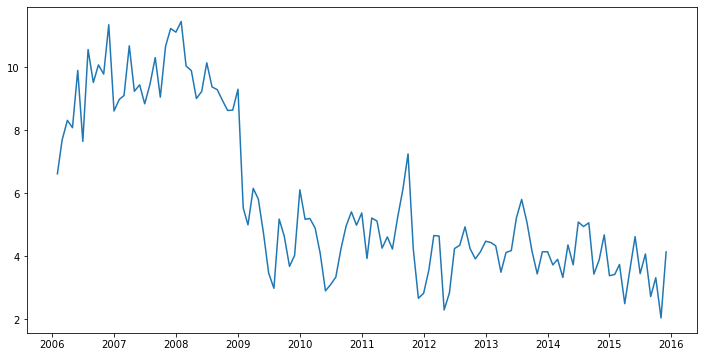

In [428]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(dfp.p);

In [483]:
dfp['2009-01-01':]

,p,dl,lt
2009-01-01,9.310447,0.0,37
2009-02-01,5.537913,3.0,38
2009-03-01,5.003372,3.0,39
2009-04-01,6.161488,3.0,40
2009-05-01,5.822788,3.0,41
...,...,...,...
2015-08-01,4.077988,3.0,116
2015-09-01,2.726711,3.0,117
2015-10-01,3.324660,3.0,118
2015-11-01,2.046558,3.0,119


Predict `p` for 6 periods using the true model and dynamic forecast:

In [492]:
start_pred = dfp.loc['2015-01-01'].name
end_pred = dfp.loc['2015-06-01'].name

mt = SARIMAX(dfp['2006-02-01':'2014-12-01'].p, exog=dfp['2006-02-01':'2014-12-01'].dl, order=(1, 0, 0), trend='c')
fitted = mt.fit(disp=0, method='bfgs', maxiter=1000)
y_pred = fitted.predict(start_pred, end_pred, exog=dfp[start_pred:end_pred].dl, dynamic=True)
y_obs = dfp.loc[start_pred:end_pred, 'p']

bias = (y_pred.values - y_obs.values)
sqe = bias**2
rmse_mt = np.sqrt(np.mean(sqe))
rmse_mt

1.1339344045441304

predict `p` for the linear trend model. ()

In [484]:
mlt = SARIMAX(dfp['2006-02-01':'2014-12-01'].p, order=(0, 0, 0), trend='ct')
fitted = mlt.fit(disp=0, method='bfgs', maxiter=1000)
y_pred = fitted.predict(start_pred, end_pred, dynamic=True)

print(fitted.params)

bias = (y_pred.values - y_obs.values)
sqe = bias**2
rmse_lt = np.sqrt(np.mean(sqe))
rmse_lt

intercept    9.544884
drift       -0.064650
sigma2       2.623731
dtype: float64


1.273317799627166

Predict `p` for the mispecified AR(1) model (p c p(-1))

In [490]:
mar1 = SARIMAX(dfp['2006-02-01':'2014-12-01'].p, order=(1, 0, 0), trend='c')
fitted = mar1.fit(disp=0, method='bfgs', maxiter=1000)
y_pred = fitted.predict(start_pred, end_pred, dynamic=True)
y_obs = dfp.loc[start_pred:end_pred, 'p']

bias = (y_pred.values - y_obs.values)
sqe = bias**2
rmse_ar = np.sqrt(np.mean(sqe))
rmse_ar

1.6315910737692396

In [497]:
print(f'True vs Linear Trend: {100*((rmse_lt-rmse_mt)/rmse_mt):.0f}%')

print(f'True vs Mispecified AR(1): {100*((rmse_ar-rmse_mt)/rmse_mt):.0f}%')

True vs Linear Trend: 12%
True vs Mispecified AR(1): 44%


# Structural break in Indian GDP?

In [540]:
dfc = pd.read_csv('data/India_Q.csv', usecols=['dateid01', 'ygr'], index_col='dateid01', parse_dates=True).dropna()
dfc.index.freq = 'QS'
dfd = dfc.eval('lygr = ygr.shift(1)', engine='python').dropna()
dfd.head()

,ygr,lygr
dateid01,,
2003-04-01,5.046689,3.210846
2003-07-01,7.369267,5.046689
2003-10-01,11.823654,7.369267
2004-01-01,8.636096,11.823654
2004-04-01,8.590761,8.636096


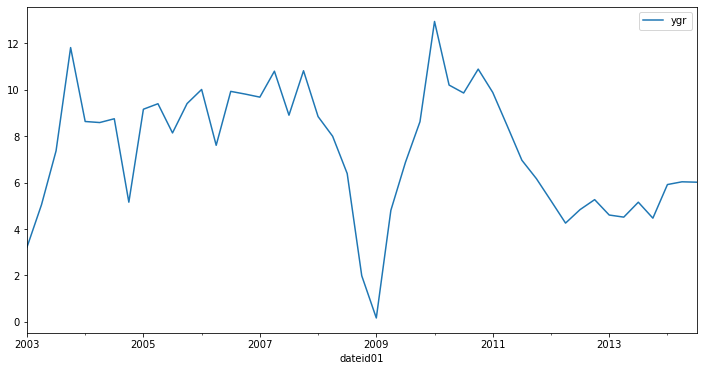

In [532]:
dfc.ygr.plot(legend=True, figsize=(12, 6));

## Question 4.49

Estimate an AR(1) model of ygr on its first lag and a constant by changing the forecast model (locate the "Run your forecast model here" and change the equation "equation eq1.ls {%v} c {%v}(-1) {%v}(-2)" to "equation eq1.ls {%v} c {%v}(-1)"). We will use an AR(1) model throughout this exercise since more realistic models have not been discussed yet. 

In [600]:
h1_predictions = []
h1_sq_errors = []
h1_bias = []

for i in pd.date_range("2008-09-01", periods=21, freq='QS'):
    preds = dyn_pred(dfd[:i].lygr, dfd[:i].ygr, steps=2, months=3, freq='QS')
    obs = dfd[(i+ pd.DateOffset(months=3)):(i+ pd.DateOffset(months=6))].ygr
    
    # Check that we're using the correct dates
    assert all(preds.index == obs.index)

    bias = (preds.values - obs.values)
    sqe = (bias)**2

    h1_predictions.append(preds)
    h1_sq_errors.append(sqe)
    h1_bias.append(bias)

h1_sq_errors = np.stack(h1_sq_errors)
h1_bias = np.stack(h1_bias)

In [601]:
print(f'MAE AR(1): {np.round(np.mean(np.abs(h1_bias[:, 1])), decimals=3)}')

print(f'RMSE AR(1): {np.round(np.sqrt(np.mean(h1_sq_errors[:, 0])), 3)}')

MAE AR(1): 1.944
RMSE AR(1): 1.992


## Question 4.50

Rolling strategy.

Now let’s see if using a rolling strategy helps to improve forecast performance (so set !strategy_rolling=1). Because we are dealing with quarterly data, set the window length (!w) to 24 quarters (which is equivalent 6 years). Since our model (i.e. AR(1)) does not have many parameters, using 24 observations is not exaggerated. Evaluate the performance of the model using a rolling strategy (!strategy_rolling=1)  for 21 estimation periods (as in the previous question) starting from 2008q4 (as in the previous question, this is maximum possible, because data for 2014q4 is not available).

In [610]:
a = pd.date_range("2008-09-01", periods=21, freq='QS')
dfd[(a[0]+ pd.DateOffset(months=3)):(a[0]+ pd.DateOffset(months=6))].ygr

dateid01
2009-01-01    0.161766
2009-04-01    4.803595
Freq: QS-JAN, Name: ygr, dtype: float64

In [616]:
dyn_pred(dfd[a[0]- pd.DateOffset(months=22*3):a[0]].lygr, dfd[a[0] - pd.DateOffset(months=22*3):a[0]].ygr, steps=2, months=3, freq='QS')

2009-01-01    5.683935
2009-04-01    7.253636
Freq: QS-JAN, dtype: float64

In [618]:
h2_predictions = []
h2_sq_errors = []
h2_bias = []

for i in pd.date_range("2008-09-01", periods=21, freq='QS'):
    start = i - pd.DateOffset(months=22*3)
    #print(start)
    # print(dfd[start:i].shape)
    preds = dyn_pred(dfd[start:i].lygr, dfd[start:i].ygr, steps=2, months=3, freq='QS')
    obs = dfd[(i+ pd.DateOffset(months=3)):(i+ pd.DateOffset(months=6))].ygr
    
    # Check that we're using the correct dates
    assert all(preds.index == obs.index)

    bias = (preds.values - obs.values)
    sqe = (bias)**2

    h2_predictions.append(preds)
    h2_sq_errors.append(sqe)
    h2_bias.append(bias)

h2_bias = np.stack(h2_bias)
h2_sq_errors = np.stack(h2_sq_errors)

In [615]:
print(f'MSE AR(1) Fixed: {np.round(np.mean(h1_sq_errors, 0), 3)}')

print(f'MSE AR(1) Moving: {np.round(np.mean(h2_sq_errors, 0), 3)}')

print(f'RMSE AR(1) Fixed: {np.round(np.sqrt(np.mean(h1_sq_errors, 0)), 3)}')

print(f'RMSE AR(1) Moving: {np.round(np.sqrt(np.mean(h2_sq_errors, 0)), 3)}')

print(f'BIAS AR(1) Fixed: {np.round(np.mean(h1_bias, 0), 3)}')

print(f'BIAS AR(1) Moving: {np.round(np.mean(h2_bias, 0), 3)}')

print(f'MAE AR(1) Fixed: {np.round(np.mean(np.abs(h1_bias), 0), decimals=3)}')

print(f'MAE AR(1) Moving: {np.round(np.mean(np.abs(h2_bias), 0), decimals=3)}')

MSE AR(1) Fixed: [3.967 4.988]
MSE AR(1) Moving: [3.67  4.324]
RMSE AR(1) Fixed: [1.992 2.233]
RMSE AR(1) Moving: [1.916 2.079]
BIAS AR(1) Fixed: [0.474 0.592]
BIAS AR(1) Moving: [0.19  0.136]
MAE AR(1) Fixed: [1.534 1.944]
MAE AR(1) Moving: [1.38  1.693]


Go understand why the results match precisely for the fixed length estimations but not for the rolling windows..

# Session 8 Fan charts

I'll just go with normal errors here and hope that I get them close enough to bootstrapped errors.

<AxesSubplot:xlabel='dateid01'>

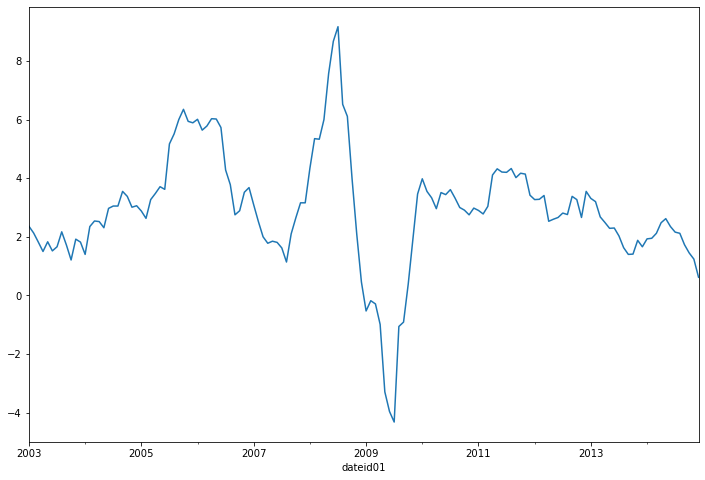

In [620]:
df.p.plot(figsize=(12, 8))

In [649]:
s = df.loc['2013-01-01'].name
e = df.loc['2013-12-01'].name

ar1b = SARIMAX(df.loc[:'2012-12-01'].p, order=(1, 0, 0), trend='c').fit(disp=0)
preds = ar1b.get_prediction(s, e, dynamic=True)
#preds.conf_int(alpha=.1)

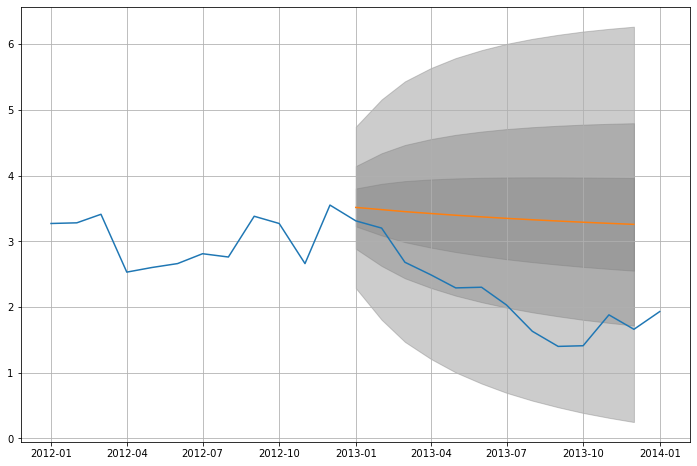

In [647]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df.p["2012-01-01":"2014-01-01"])

ax.plot(preds.summary_frame()['mean'])
ci_90 = preds.conf_int(alpha=.1)
ci_60 = preds.conf_int(alpha=.4)
ci_30 = preds.conf_int(alpha=.7)


ax.fill_between(ci_90.index, ci_90['lower p'], ci_90['upper p'], color='gray', alpha=0.4, label='90% interval')
ax.fill_between(ci_90.index, ci_60['lower p'], ci_60['upper p'], color='gray', alpha=0.4, label='60% interval')
ax.fill_between(ci_90.index, ci_30['lower p'], ci_30['upper p'], color='gray', alpha=0.4, label='30% interval')

ax.grid()

In [651]:
s = df.loc['2013-01-01'].name
e = df.loc['2014-12-01'].name

ar1b = SARIMAX(df.loc[:'2012-12-01'].p, order=(1, 0, 0), trend='c').fit(disp=0)
preds = ar1b.get_prediction(s, e, dynamic=True)
# preds.conf_int(alpha=.1)

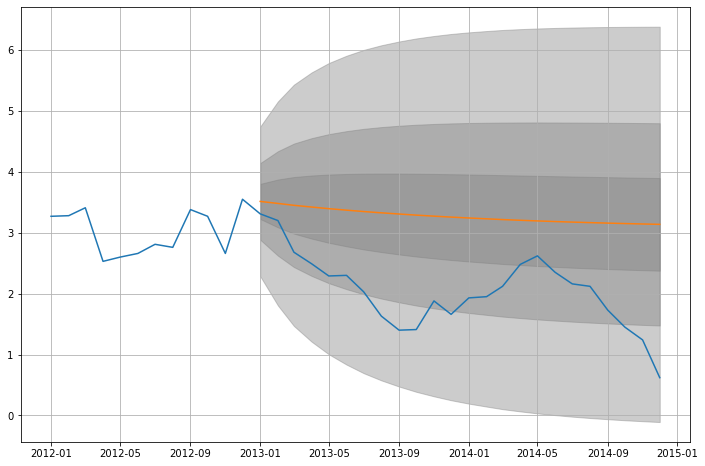

In [652]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df.p["2012-01-01":"2015-01-01"])

ax.plot(preds.summary_frame()['mean'])
ci_90 = preds.conf_int(alpha=.1)
ci_60 = preds.conf_int(alpha=.4)
ci_30 = preds.conf_int(alpha=.7)


ax.fill_between(ci_90.index, ci_90['lower p'], ci_90['upper p'], color='gray', alpha=0.4, label='90% interval')
ax.fill_between(ci_90.index, ci_60['lower p'], ci_60['upper p'], color='gray', alpha=0.4, label='60% interval')
ax.fill_between(ci_90.index, ci_30['lower p'], ci_30['upper p'], color='gray', alpha=0.4, label='30% interval')

ax.grid()